92: 1-2//1 dataset (24,834 extras samples, using primary bird), no label smooth, no backbone tuning
93: No extras


# Baseline for Pytorch Lightning based submission 

In [1]:
#Python Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import functools
import time
import warnings
warnings.filterwarnings('ignore')

#ML Imports
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchmetrics
import timm
import albumentations as A
import torchaudio

#Audio Imports
import librosa
import librosa as lb
import gc

In [2]:
class Config:
    NUM_CLASSES = 264 
    IMAGE_SIZE = 256
    MODEL = 'tf_efficientnetv2_s' #'tf_efficientnet_b0_ns' #'tf_efficientnetv2_s_in21k'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    TEST_PATH= '/kaggle/input/birdclef-2023/test_soundscapes/'
    LOSS = 'CrossEntropy' # or BCE
    SR = 32000
    DURATION = 5
    POST_PROCESS = False
    MODEL_CKPT = '/kaggle/input/birdclef23-exp90/exp90-epoch10-1.ckpt'

In [3]:
 class Audio:
    SR = 32000
    DURATION = 5
    N_MELS = 128 
    FMIN = 20
    FMAX = 14000
    WINDOW = 1024  
    HOP_LENGTH = 312
    N_FFT = 1024

In [4]:
torch.set_flush_denormal(True)
bird_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
bird_names.append('no-call')
bird_names.sort()
Config.NUM_CLASSES = len(bird_names)
nocall_idx = bird_names.index("no-call")
print(f'The index of the no-call class is {nocall_idx}')

The index of the no-call class is 152


In [5]:
#decorator to time different fuctions
def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer


def compute_melspec(y, 
                    sr=Audio.SR,  
                    n_mels=Audio.N_MELS, 
                    n_fft=Audio.N_FFT, 
                    hop_length = Audio.HOP_LENGTH, 
                    fmin=Audio.FMIN, 
                    fmax=Audio.FMAX): 
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    melspec = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, hop_length=hop_length)
    melspec = lb.power_to_db(melspec)#.astype(np.float32)
    return melspec



def mono_to_color(X, eps=1e-6, mean=None, std=None): # Normalize to [0, 1]
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales them onto a range of 1.
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image, for the ablu_trasformations
    return X



def crop_or_pad(y, length):
    if len(y) < length:
        n_repeats = length // len(y)
        epsilon = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:epsilon]]) 
    elif len(y) > length:
        y = y[:length]
    return y


def reshape_image(arr):  #chop the image in half along the horizontal dimension and stack to make more square
    cols = arr.shape[1]//2 
    remainder = arr.shape[1] % 2
    half1 = arr[:, :cols + remainder]
    half2 = arr[:, cols:]
    arr =  np.vstack((half1, half2))
    return arr

In [6]:
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(Config.TEST_PATH).glob("*.ogg")],
    columns = ["filename", "name" ,"id", "path"]
)
print(df_test.shape)
df_test.head()

(1, 4)


,filename,name,id,path
0,soundscape_29201,soundscape,29201,/kaggle/input/birdclef-2023/test_soundscapes/s...


In [7]:
def normalize_audio(y):
    max_vol = np.abs(y).max()
    y = y * 1 / max_vol
    return(y)
    

mean = (0.485, 0.456, 0.406) # RGB
std = (0.229, 0.224, 0.225) # RGB

albu_transforms = {'valid' : A.Compose([
                A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
                A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
                A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE)])}

In [8]:
class WaveformDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df
        self.sr = Audio.SR
        self.n_mels = Audio.N_MELS
        self.fmin = Audio.FMIN
        self.fmax = Audio.FMAX
        self.duration = Audio.DURATION
        self.audio_length = self.duration*self.sr
        self.res_type = "kaiser_fast"
        
    def __len__(self):
        return self.df.shape[0]
    
    
    def audio_to_image(self, audio):
        audio = crop_or_pad(audio, self.audio_length)
        audio = normalize_audio(audio)
        image = compute_melspec(audio)
        image = reshape_image(image)
        image = mono_to_color(image)
        image = albu_transforms['valid'](image=image)['image']#[:,:,0]
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        return image
    
    
    def read_file(self, filepath):
        audio, orig_sr = torchaudio.load(filepath)
        audio = audio.squeeze().numpy()

        if orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
       
        audios = []
        for i in range(self.audio_length, len(audio) + self.audio_length, self.audio_length):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
        images = [self.audio_to_image(audio) for audio in audios] 
        images = np.stack(images)   # Stacks the list of 3d arrays, into a single 4d array
        return images
    
        
    def __getitem__(self, idx):
        images = self.read_file(self.df.loc[idx, "path"])
        return images

In [9]:
ds_test = WaveformDataset(df_test)
print(f'The shape of the 88th image, from the first file: {ds_test[0][88][0].shape}')
print(f'The number of test dataset {len(ds_test)}')

The shape of the 88th image, from the first file: (256, 256)
The number of test dataset 1


In [10]:
def show_batch(img_ds, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, ds_test[0].shape[0] -1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first few images
        img = img_ds[0][index][0]
        shape=img.shape
        scaled_data = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = lb.display.specshow(scaled_data, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title= f'Spectrogram scaled onto [0,1] {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f")        

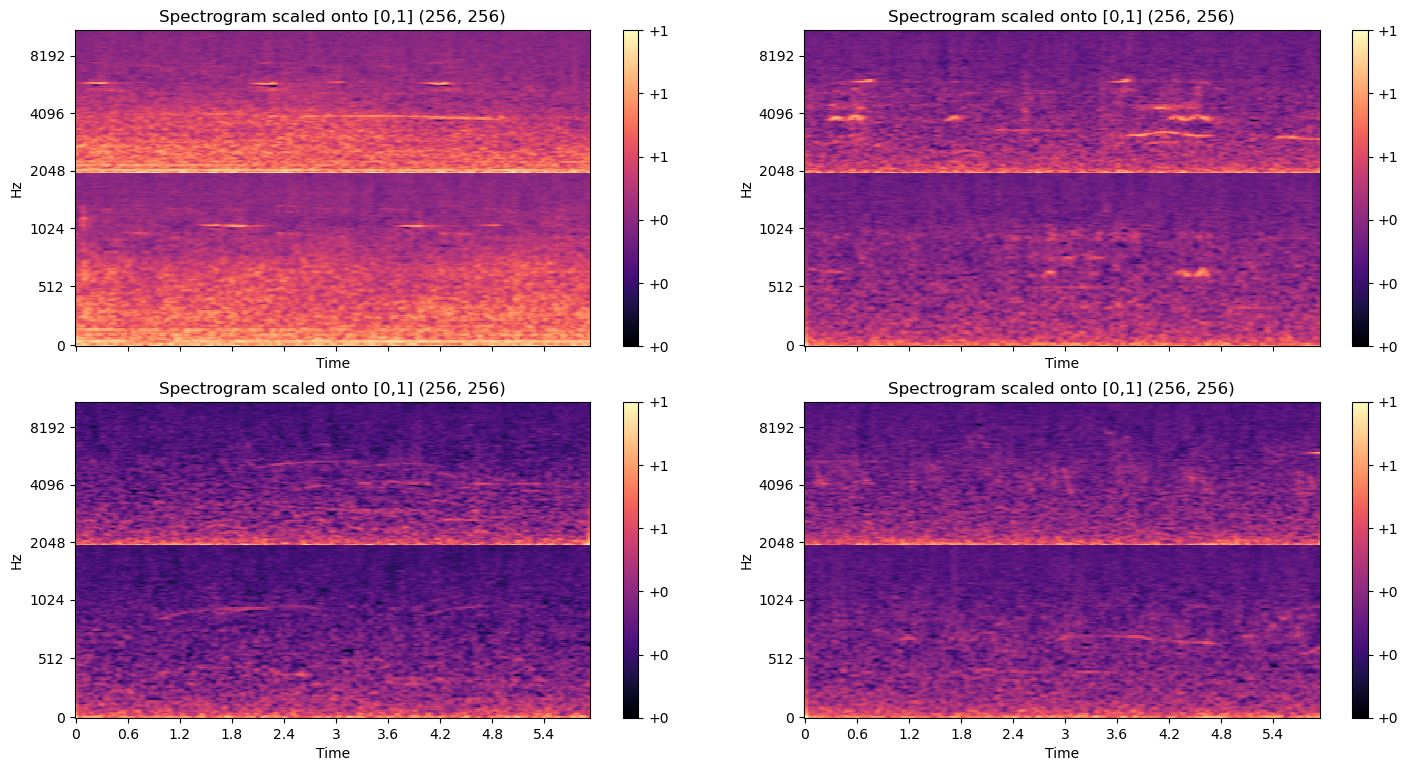

In [11]:
show_batch(ds_test, 2, 2)

In [12]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.MODEL, num_classes = Config.NUM_CLASSES, pretrained = False):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, num_classes))

    def forward(self,images):
        logits = self.backbone(images)
        return logits

In [13]:
def post_process(arr, nocall_idx):
    new_list = []

    #average each 5 second row with the one before and the one after, since these are likely to have the same birds
    #arr_view_1 = np.concatenate((in_arr[:1,:], in_arr[:-1,:]), axis=0)
    #arr_view_2 = np.concatenate((in_arr[1:,:], in_arr[-1:,:]), axis=0)
    #arr = (0.6*in_arr + 0.2*arr_view_1 + 0.2*arr_view_2).copy()      
    #print(type(arr))
        
    #suppress any predictions where no-call was predicted, since this has a higher accuracy anyway
    arr_view = np.concatenate((arr[:,:nocall_idx], arr[:,nocall_idx+1:]), axis=1)
    row_max = np.amax(arr_view, axis=1)
    mask = (row_max < arr[:,nocall_idx]) & (arr[:,nocall_idx] > 0.5)
    #print(mask)
    arr[mask] = 0
    #mask = arr < 0.01  #drop any really small values
    #arr[mask] = 0

    new_list.append(arr)
    return arr  

In [14]:
@timer
def predict(data_loader, model):      
    model.to('cpu')
    model.eval()    
    predictions = []
    for en in range(len(ds_test)):
        images = torch.from_numpy(ds_test[en])
        with torch.no_grad():
            logits = model(images).detach().cpu().numpy()
            if Config.POST_PROCESS:
                logits = post_process(logits, nocall_idx)
            if Config.LOSS == 'BCE':
                output_probs = 1 / (1 + np.exp(-logits))
            else:    # Softmax
                output_probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
            predictions.append(output_probs)
    return predictions

In [15]:
print("Model Creation")
model = BirdClefModel.load_from_checkpoint(Config.MODEL_CKPT, train_dataloader=None,validation_dataloader=None) 
print("Running Inference..")
preds = predict(ds_test, model)   
gc.collect()
torch.cuda.empty_cache()

Model Creation
Running Inference..
Finished 'predict' in 26.2945 secs


In [16]:
sub_df = pd.DataFrame(columns=['row_id']+bird_names)
sub_df

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1


# Generate Submission csv

In [17]:
filenames = df_test.filename.values.tolist()

for i, file in enumerate(filenames):
    pred = preds[i]
    num_rows = len(pred)
    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+bird_names)
    df['row_id'] = row_ids
    df[bird_names] = pred
    sub_df = pd.concat([sub_df,df]).reset_index(drop=True)

nocall = sub_df['no-call']
sub_df = sub_df.drop('no-call', axis=1).reset_index(drop=True)

In [18]:
sub_df

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0.009507,0.000922,0.000752,0.000022,0.000455,0.000473,0.000452,0.000814,0.010038,...,2.297685e-05,0.000069,0.000096,0.000915,3.035776e-05,0.000563,0.000049,0.000256,0.000092,0.000307
1,soundscape_29201_10,0.000658,0.029386,0.000026,0.000117,0.000291,0.002002,0.000138,0.000107,0.001330,...,1.359836e-06,0.001385,0.000693,0.005274,2.050950e-05,0.002514,0.000087,0.000039,0.000040,0.000804
2,soundscape_29201_15,0.000176,0.001163,0.000031,0.000010,0.000003,0.000592,0.000023,0.000001,0.000335,...,3.500103e-08,0.000011,0.000366,0.000517,4.001570e-07,0.000153,0.000001,0.000747,0.000003,0.000304
3,soundscape_29201_20,0.000268,0.000969,0.000627,0.000936,0.000271,0.000314,0.000286,0.003050,0.000141,...,1.260720e-05,0.001402,0.000251,0.024686,9.858342e-06,0.000228,0.000042,0.000568,0.000040,0.000487
4,soundscape_29201_25,0.000101,0.001806,0.000165,0.000104,0.000246,0.000303,0.000079,0.000390,0.000100,...,3.914934e-05,0.000180,0.000175,0.000633,2.147096e-05,0.000425,0.000033,0.000108,0.000043,0.000588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,soundscape_29201_580,0.000285,0.001339,0.000266,0.000076,0.000412,0.000365,0.000102,0.000873,0.000099,...,2.605002e-05,0.000859,0.000155,0.000864,5.139372e-05,0.000339,0.000054,0.000499,0.000060,0.000401
116,soundscape_29201_585,0.003823,0.002888,0.000133,0.000033,0.000069,0.000531,0.190601,0.000014,0.003663,...,5.299783e-05,0.000040,0.000097,0.000231,1.680677e-04,0.000995,0.000114,0.001638,0.000191,0.000199
117,soundscape_29201_590,0.001582,0.006653,0.000087,0.000415,0.000831,0.000212,0.006111,0.000176,0.000416,...,4.231420e-06,0.001415,0.000922,0.008070,2.361652e-05,0.001193,0.000266,0.000452,0.000010,0.000581
118,soundscape_29201_595,0.000262,0.005520,0.000138,0.000034,0.000406,0.000158,0.000165,0.001135,0.000199,...,1.281711e-06,0.000394,0.000346,0.002501,8.468810e-06,0.000267,0.000015,0.000018,0.000009,0.000157


In [19]:
sub_df.to_csv('submission.csv',index=False)